# Generate Figures for Word2Vec Year Models

The goal of this notebook is to observe how words are shifting through time since 2000. The caveat here is that words have to been present within all time periods in order to be present for this task. Ideally words to be examined so far are: 'expression', 'are', 'interleukin-18', '95%ci', and 'p53'.

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import plotnine as p9
import tqdm
from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

from biovectors_modules.plot_helper import (
    plot_local_global_distances,
    plot_token_timeline,
    plot_wordcloud_neighbors,
    plot_wordcloud_neighbors_gif,
)
from biovectors_modules.word2vec_analysis_helper import (
    generate_timeline,
    get_neighbors,
    project_token_timeline,
)

# Load Models to Observe Changes

## Load Aligned Word Vectors

In [2]:
aligned_models = pickle.load(open("output/aligned_word_vectors_2000_2020.pkl", "rb"))

In [3]:
year_comparison_dict = {
    "_".join(comparison_file.stem.split("_")[0:2]): (
        pd.read_csv(str(comparison_file), sep="\t")
    )
    for comparison_file in (list(Path("output/year_distances_2000_2020").rglob("*tsv")))
}
list(year_comparison_dict.keys())[0:3]

['2000_2018', '2000_2004', '2000_2013']

In [4]:
year_comparison_dict["2000_2005"].sort_values("global_dist", ascending=False)

,token,global_dist,local_dist,shift
12847,macs,1.553888,1.977319,-0.423431
6754,dependable,1.451394,1.590620,-0.139226
16381,pop,1.434292,1.687357,-0.253065
6931,dgtp,1.392785,1.685370,-0.292584
14900,oldest,1.392103,1.889026,-0.496923
...,...,...,...,...
14433,nicht,0.073248,0.001997,0.071251
7800,einer,0.072171,0.002559,0.069612
3781,bei,0.070235,0.001933,0.068302
416,1.6,0.069557,0.001256,0.068301


## Train UMAP Model to Project Time Shifts into Two Dimensional Space

The goal here is to train a TSNE model that projects all words from 2000 to 2020 into a two dimensional space. Allows one to visually track how a word vector is shifting through time.

In [5]:
origin_df = aligned_models["2000"]
word_vectors = list(
    map(
        lambda x: x.query(f"token in {origin_df.token.tolist()}")
        .sort_values("token")
        .set_index("token")
        .values,
        aligned_models.values(),
    )
)

In [6]:
word_models_stacked = np.vstack(word_vectors)
file_name = "output/2000_2020_umap_model"

In [7]:
if not Path(file_name).exists():
    Path(file_name).mkdir(parents=True)
    model = ParametricUMAP(
        verbose=True, metric="cosine", random_state=100, low_memory=True, n_neighbors=25
    )
    embedding = model.fit_transform(word_models_stacked)
    model.save(file_name)
else:
    model = load_ParametricUMAP(file_name)
model.verbose = False

Mon May 17 10:37:26 2021 Building and compiling search function
Pickle of ParametricUMAP model loaded from output/2000_2020_umap_model_replace/model.pkl
Keras encoder model loaded from output/2000_2020_umap_model_replace/encoder
Keras full model loaded from output/2000_2020_umap_model_replace/parametric_model


# Observe Diachronic Vector Changes

Global distance measures how far a word has moved within semantic space. This measure captures how words change globally across time periods. The greater the distance the more semantic change a word has been subjected towards.
The word clouds depict the neighbors for each word vector. The size for each token  appears to be different but size doesn't matter in this case. Each word has equal weighting.

## Are

In [8]:
token_timeline_df = generate_timeline(year_comparison_dict, "are")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
4066,are,0.234041,0.045146,0.188895,2000_2018
2860,are,0.147071,0.012223,0.134848,2000_2004
4007,are,0.252415,0.055406,0.197009,2000_2013
4062,are,0.236442,0.042304,0.194138,2000_2017
2535,are,0.021539,0.000434,0.021105,2000_2001


In [9]:
token_timeline_low_dim_df = project_token_timeline(
    "are", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,8.098224,1.340032,2020,are,main
26,7.784721,1.074924,2019,are,main
52,7.935903,1.428181,2018,are,main
78,8.049175,1.390639,2017,are,main
104,7.969232,1.423884,2016,are,main
130,8.007701,1.303195,2015,are,main
156,7.987484,1.259464,2014,are,main
182,8.084186,1.337816,2013,are,main
208,7.920649,1.195688,2012,are,main
234,7.837080,1.162971,2011,are,main


In [10]:
global_distance, local_distance = plot_local_global_distances(token_timeline_df, "are")

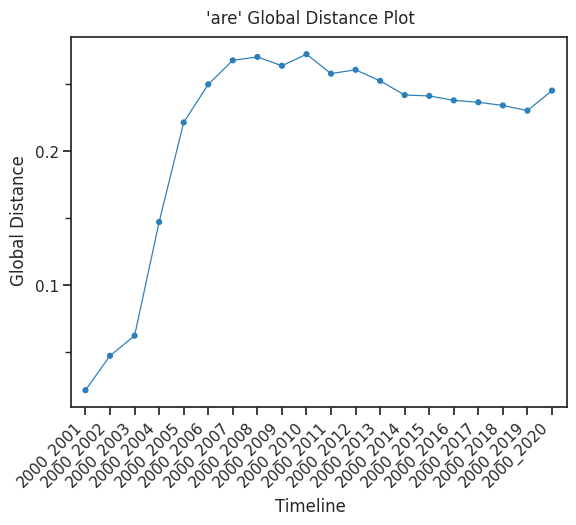

<ggplot: (-9223363252681585748)>

In [11]:
global_distance

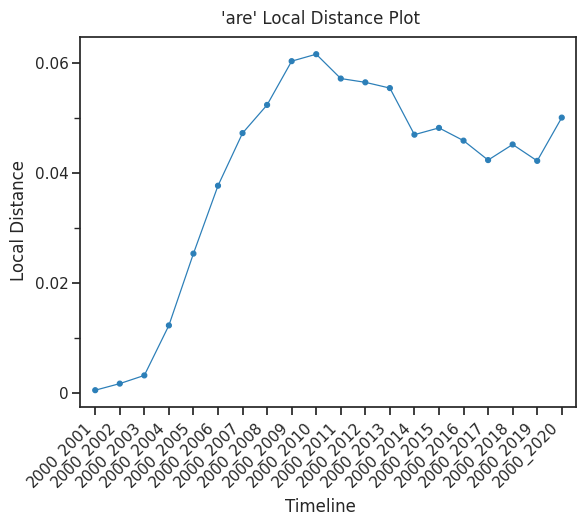

<ggplot: (8784173100373)>

In [12]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/are_time_plot.png


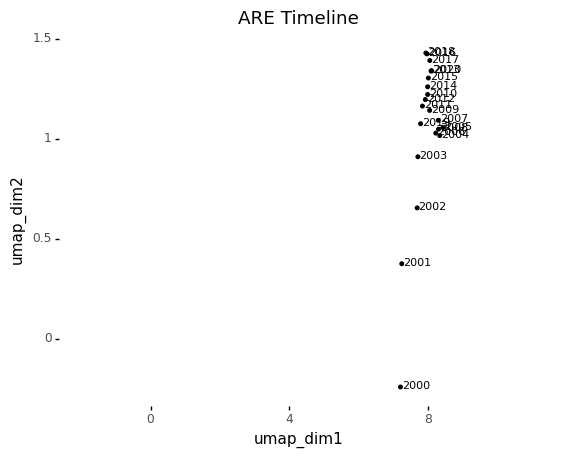

<ggplot: (-9223363252690382192)>


In [13]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/are_time_plot.png")
print(g)

In [14]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/are.gif"
)

![are gif here](output/wordcloud_plots_2000_2020/are.gif)

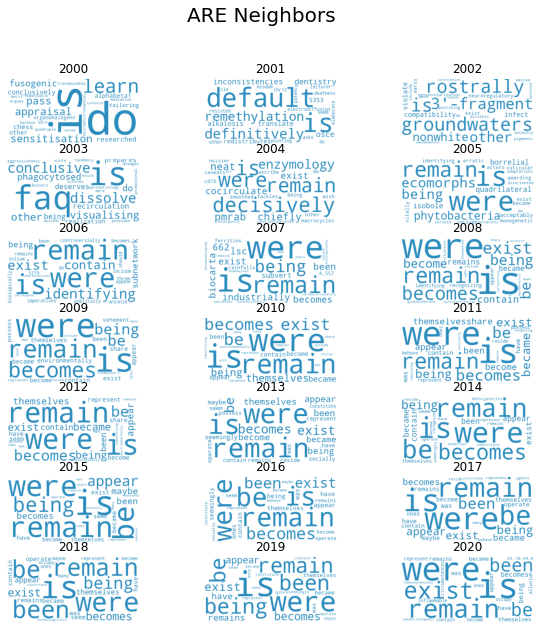

In [15]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/are.png"
)

## Expression

In [16]:
token_timeline_df = generate_timeline(year_comparison_dict, "expression")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
10693,expression,0.282541,0.029603,0.252938,2000_2018
8021,expression,0.206998,0.009181,0.197817,2000_2004
10556,expression,0.315693,0.034903,0.280790,2000_2013
10686,expression,0.290986,0.033448,0.257538,2000_2017
7326,expression,0.023785,0.000198,0.023587,2000_2001


In [17]:
token_timeline_low_dim_df = project_token_timeline(
    "expression", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-1.334953,1.446408,2020,expression,main
26,-1.345318,1.585380,2019,expression,main
52,-1.320328,1.580766,2018,expression,main
78,-1.181733,1.558368,2017,expression,main
104,-1.218152,1.496666,2016,expression,main
130,-1.240080,1.642789,2015,expression,main
156,-1.122874,1.703836,2014,expression,main
182,-1.213744,1.594719,2013,expression,main
208,-1.097609,1.538504,2012,expression,main
234,-1.206758,1.536462,2011,expression,main


In [18]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, "expression"
)

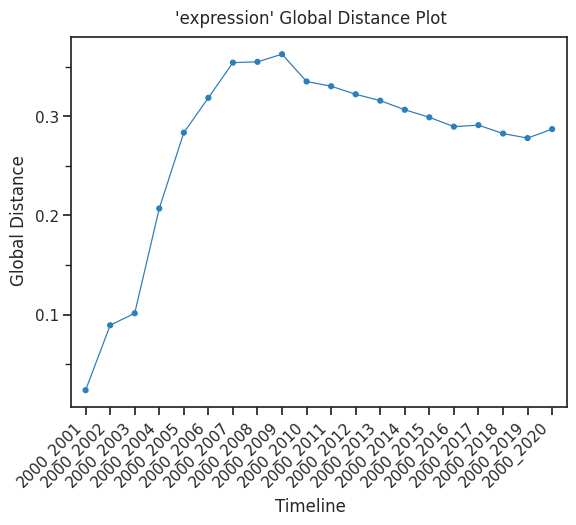

<ggplot: (8784145262754)>

In [19]:
global_distance

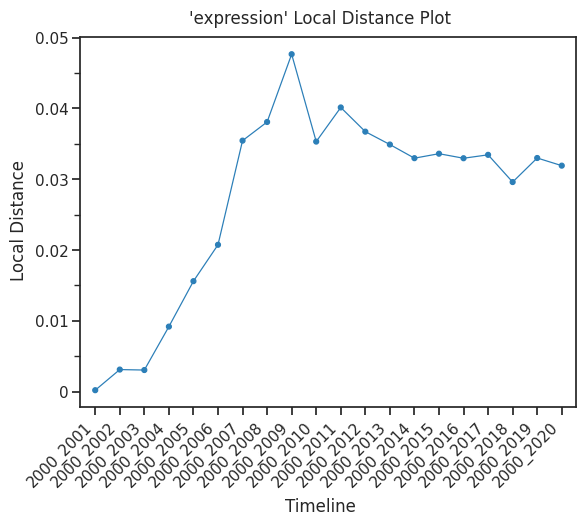

<ggplot: (-9223363252709596556)>

In [20]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/expression_time_plot.png


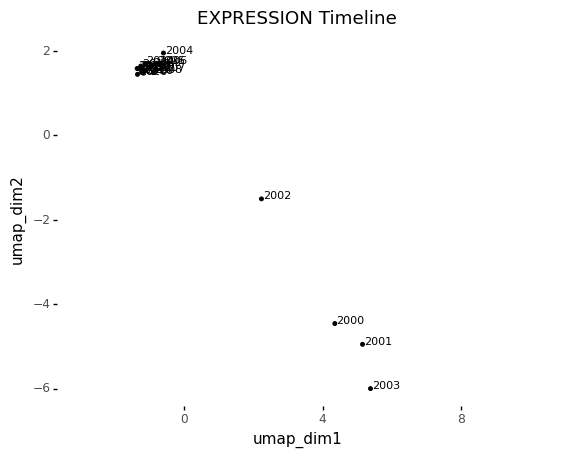

<ggplot: (8784172620850)>


In [21]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/expression_time_plot.png")
print(g)

In [22]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/expression.gif",
)

![expression gif here](output/wordcloud_plots_2000_2020/expression.gif)

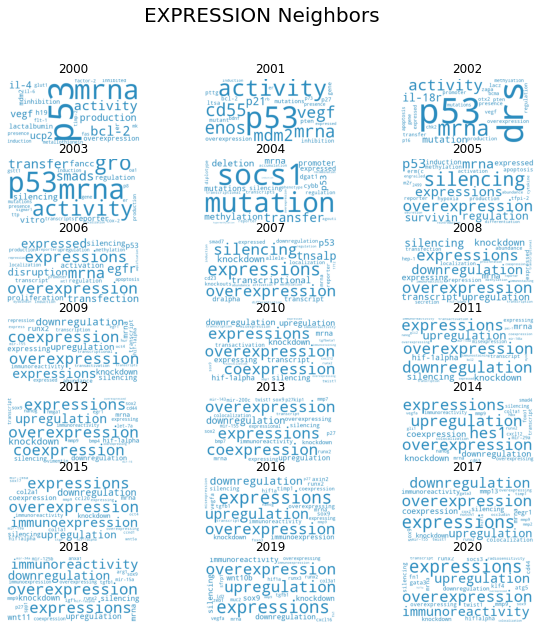

In [23]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/expression.png",
)

## 95%ci

In [24]:
token_timeline_df = generate_timeline(year_comparison_dict, "95%ci")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
2582,95%ci,0.595492,0.199135,0.396357,2000_2018
1717,95%ci,0.116723,0.002734,0.113989,2000_2004
2534,95%ci,0.552265,0.169995,0.382270,2000_2013
2574,95%ci,0.592461,0.191182,0.401279,2000_2017
1499,95%ci,0.211207,0.007353,0.203853,2000_2001


In [25]:
token_timeline_low_dim_df = project_token_timeline(
    "95%ci", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,5.993356,6.961666,2020,95%ci,main
26,6.119041,6.884256,2019,95%ci,main
52,6.119845,6.904584,2018,95%ci,main
78,6.216185,7.155980,2017,95%ci,main
104,5.970484,6.849502,2016,95%ci,main
130,6.017646,6.717826,2015,95%ci,main
156,5.967877,6.787189,2014,95%ci,main
182,6.103976,6.779191,2013,95%ci,main
208,5.995938,6.961964,2012,95%ci,main
234,6.089817,7.083745,2011,95%ci,main


In [26]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="95%ci"
)

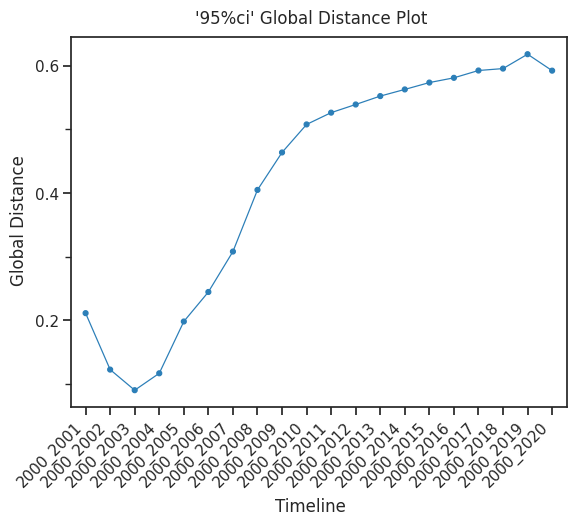

<ggplot: (-9223363253360521875)>

In [27]:
global_distance

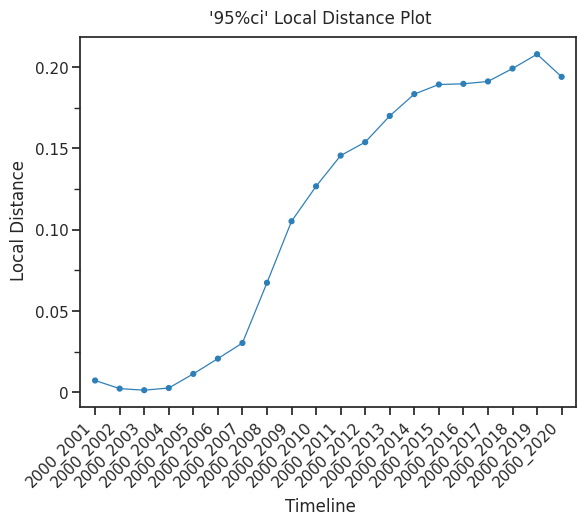

<ggplot: (-9223363253360518975)>

In [28]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/95_ci_time_plot.png


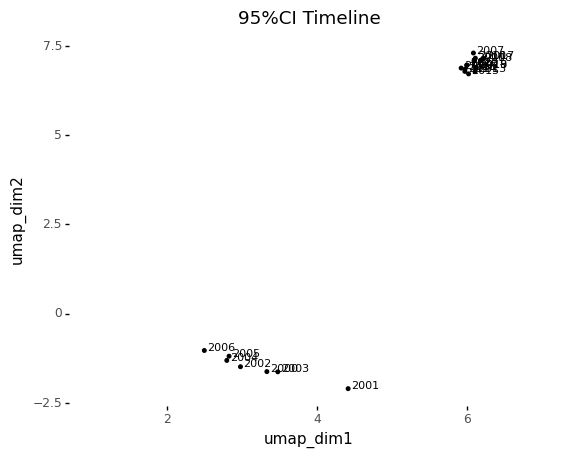

<ggplot: (-9223363252682323708)>


In [29]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/95_ci_time_plot.png")
print(g)

In [30]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/95%ci.gif",
)

![95%ci gif here](output/wordcloud_plots_2000_2020/95%ci.gif)

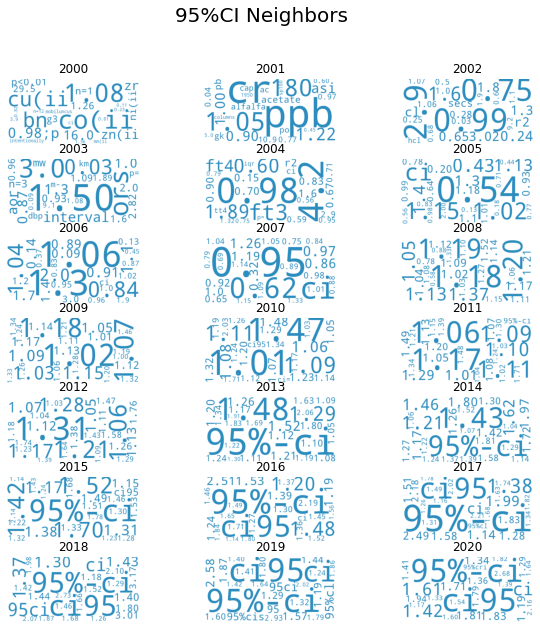

In [31]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/95%ci.png",
)

## interleukin-18

In [32]:
token_timeline_df = generate_timeline(year_comparison_dict, "interleukin-18")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
14341,interleukin-18,0.708663,0.303082,0.405581,2000_2018
10785,interleukin-18,0.449621,0.030766,0.418855,2000_2004
14181,interleukin-18,0.653436,0.265670,0.387766,2000_2013
14336,interleukin-18,0.698113,0.315984,0.382129,2000_2017
9890,interleukin-18,0.215279,0.010709,0.204570,2000_2001


In [33]:
token_timeline_low_dim_df = project_token_timeline(
    "interleukin-18", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-1.467067,-0.263024,2020,interleukin-18,main
26,-1.011630,0.236608,2019,interleukin-18,main
52,-0.935505,0.231667,2018,interleukin-18,main
78,-0.864157,0.141148,2017,interleukin-18,main
104,-1.089436,0.080882,2016,interleukin-18,main
130,-1.007107,0.073763,2015,interleukin-18,main
156,-1.082858,-0.023339,2014,interleukin-18,main
182,-1.238211,-0.233735,2013,interleukin-18,main
208,-1.080349,-0.169433,2012,interleukin-18,main
234,-1.365364,-0.293020,2011,interleukin-18,main


In [34]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="interleukin-18"
)

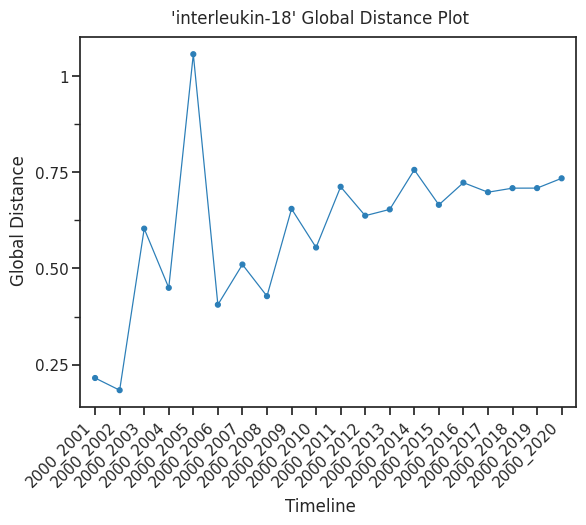

<ggplot: (-9223363252682439308)>

In [35]:
global_distance

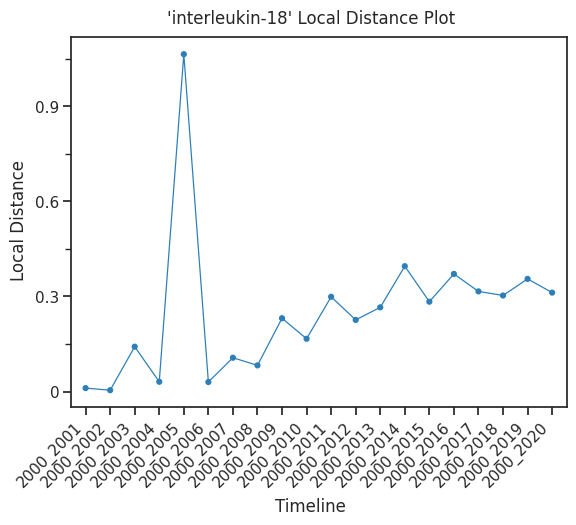

<ggplot: (8784145266594)>

In [36]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/interleukin18_time_plot.png


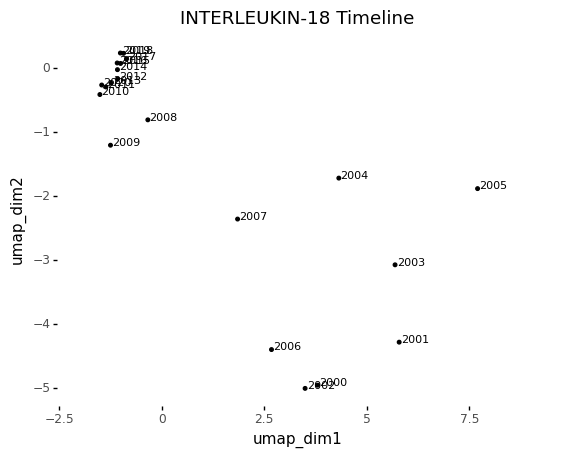

<ggplot: (8784145266482)>


In [37]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/interleukin18_time_plot.png")
print(g)

In [38]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/interleukin-18.gif",
)

![interleukin-18 gif here](output/wordcloud_plots_2000_2020/interleukin-18.gif)

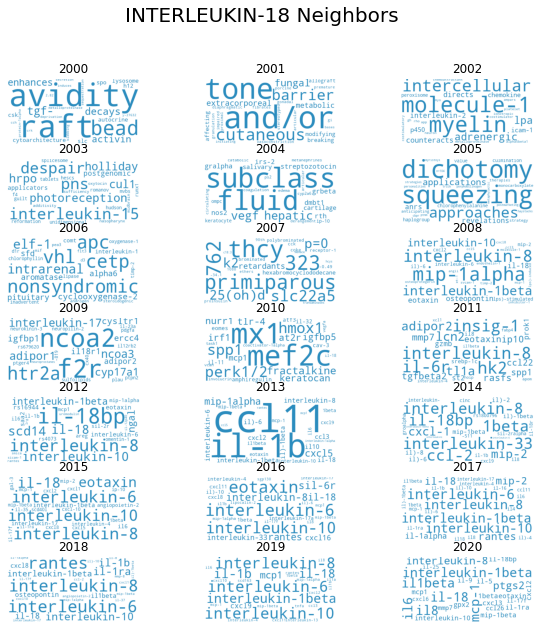

In [39]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/interleukin_18.png",
)

## p53

In [40]:
token_timeline_df = generate_timeline(year_comparison_dict, "p53")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
19106,p53,0.424283,0.063290,0.360993,2000_2018
14288,p53,0.088355,0.003053,0.085302,2000_2004
18906,p53,0.442968,0.069976,0.372992,2000_2013
19115,p53,0.437162,0.070563,0.366599,2000_2017
13075,p53,0.030049,0.000582,0.029467,2000_2001


In [41]:
token_timeline_low_dim_df = project_token_timeline(
    "p53", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-2.106145,0.620707,2020,p53,main
26,-2.060314,0.799558,2019,p53,main
52,-2.180565,0.710931,2018,p53,main
78,-2.102571,0.734277,2017,p53,main
104,-2.141838,0.788237,2016,p53,main
130,-2.119601,0.698011,2015,p53,main
156,-2.069216,0.755260,2014,p53,main
182,-2.170913,0.721939,2013,p53,main
208,-2.186035,0.502398,2012,p53,main
234,-2.289206,0.328015,2011,p53,main


In [42]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="p53"
)

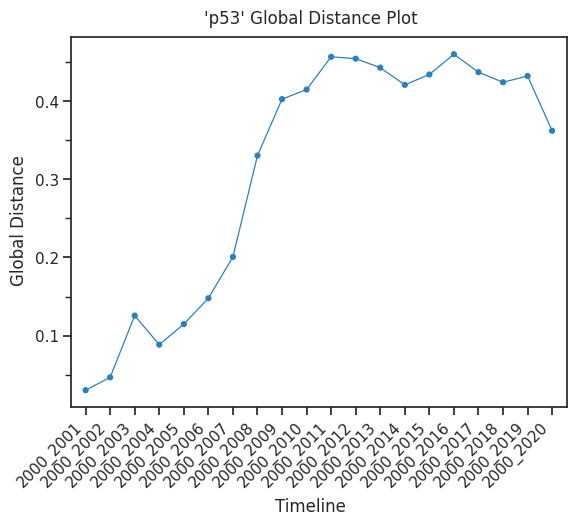

<ggplot: (-9223363252682329049)>

In [43]:
global_distance

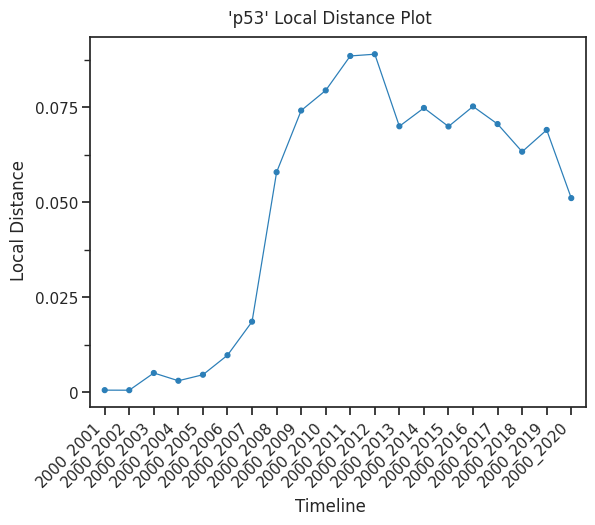

<ggplot: (8784172299254)>

In [44]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/p53_time_plot.png


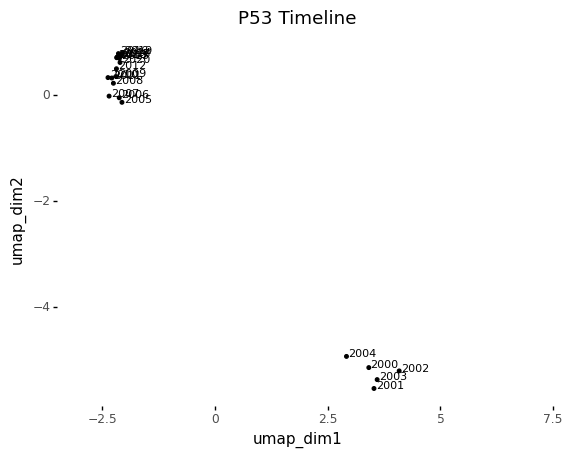

<ggplot: (-9223363252681702526)>


In [45]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/p53_time_plot.png")
print(g)

In [46]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/p53.gif"
)

![p53 gif here](output/wordcloud_plots_2000_2020/p53.gif)

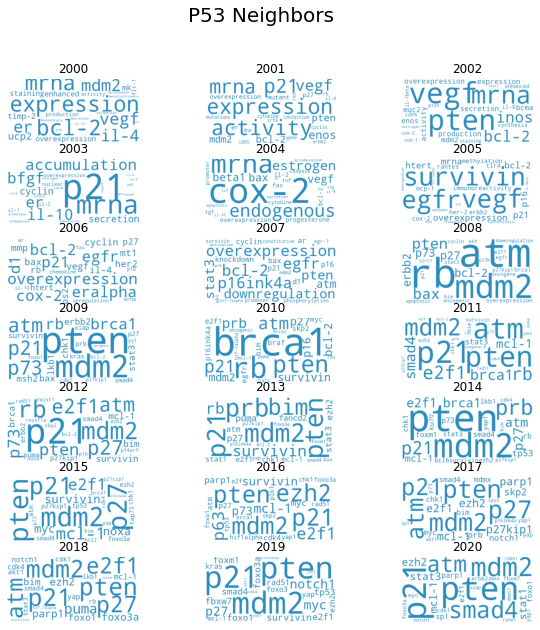

In [47]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/p53.png"
)

## Cystic

In [48]:
token_timeline_df = generate_timeline(year_comparison_dict, "cystic")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
7955,cystic,0.762114,0.409452,0.352662,2000_2018
5878,cystic,0.185009,0.009923,0.175086,2000_2004
7852,cystic,0.738315,0.406006,0.332309,2000_2013
7957,cystic,0.755497,0.441550,0.313946,2000_2017
5359,cystic,0.049545,0.000464,0.049081,2000_2001


In [49]:
token_timeline_low_dim_df = project_token_timeline(
    "cystic", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,2.960795,1.668464,2020,cystic,main
26,2.873632,1.497365,2019,cystic,main
52,2.954787,1.564626,2018,cystic,main
78,2.962331,1.569726,2017,cystic,main
104,2.975846,1.646677,2016,cystic,main
130,2.933419,1.584813,2015,cystic,main
156,3.052127,1.601114,2014,cystic,main
182,2.847256,1.584680,2013,cystic,main
208,3.011526,1.622867,2012,cystic,main
234,3.085356,1.550369,2011,cystic,main


In [50]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="cystic"
)

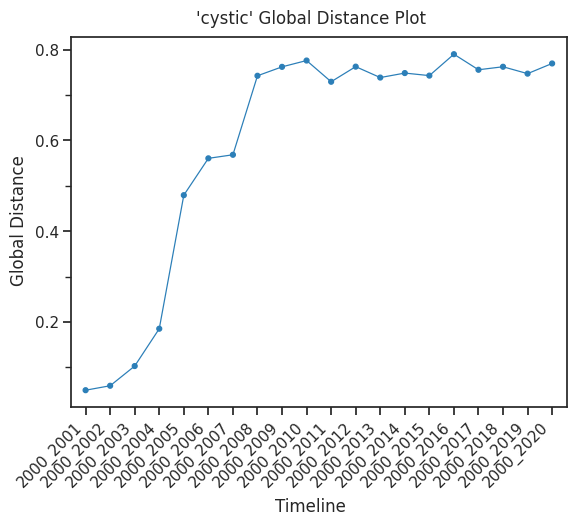

<ggplot: (-9223363252681204343)>

In [51]:
global_distance

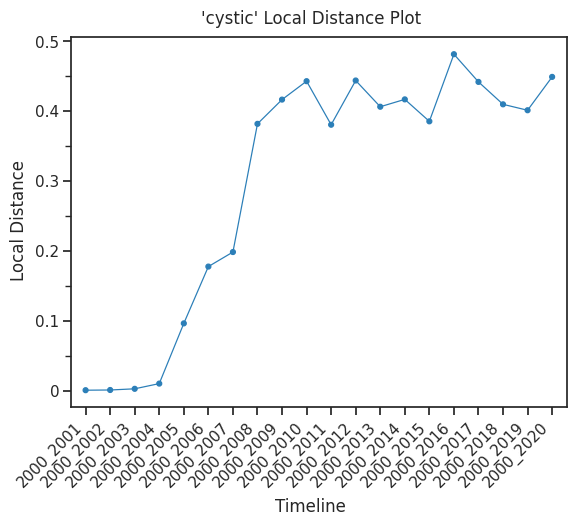

<ggplot: (8784172785202)>

In [52]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/cystic_time_plot.png


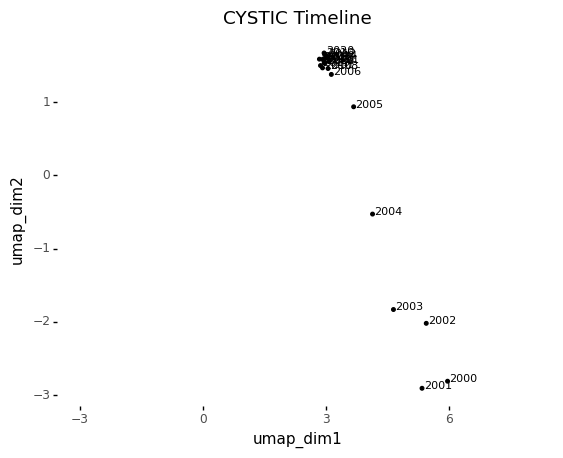

<ggplot: (8784172785286)>


In [53]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/cystic_time_plot.png")
print(g)

In [54]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/cystic.gif",
)

![cystic_gif here](output/wordcloud_plots_2000_2020/cystic.gif)

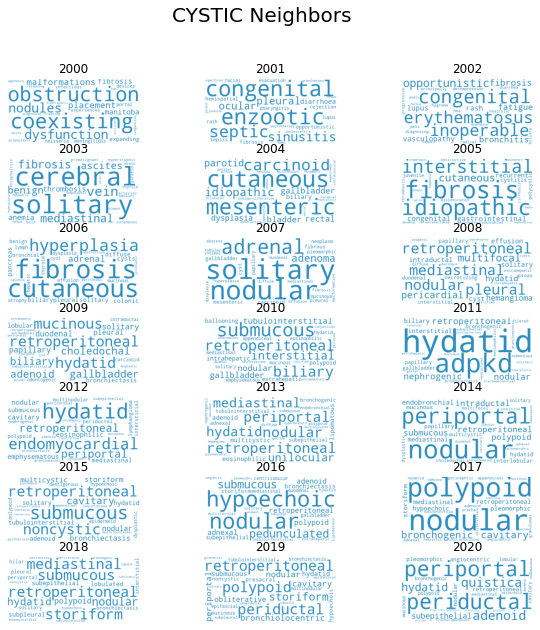

In [55]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df,
    plot_filename="output/wordcloud_plots_2000_2020/cystic.png",
)

## Cell

In [56]:
token_timeline_df = generate_timeline(year_comparison_dict, "cell")
token_timeline_df.head()

,token,global_dist,local_dist,shift,year_label
6102,cell,0.209459,0.016173,0.193286,2000_2018
4381,cell,0.124436,0.002812,0.121624,2000_2004
6017,cell,0.221720,0.017427,0.204293,2000_2013
6108,cell,0.209036,0.014598,0.194438,2000_2017
3967,cell,0.043076,0.000527,0.042549,2000_2001


In [57]:
token_timeline_low_dim_df = project_token_timeline(
    "cell", aligned_models, model, neighbors=25
)
token_timeline_low_dim_df.query("label=='main'")

,umap_dim1,umap_dim2,year,token,label
0,-0.140307,0.236258,2020,cell,main
26,-0.302440,0.758960,2019,cell,main
52,-0.034326,0.768443,2018,cell,main
78,-0.686023,0.693024,2017,cell,main
104,0.419698,0.911467,2016,cell,main
130,-0.068849,0.791128,2015,cell,main
156,-0.556585,0.738933,2014,cell,main
182,0.241697,0.949651,2013,cell,main
208,0.295078,0.868585,2012,cell,main
234,-0.021986,0.638404,2011,cell,main


In [58]:
global_distance, local_distance = plot_local_global_distances(
    token_timeline_df, token="cell"
)

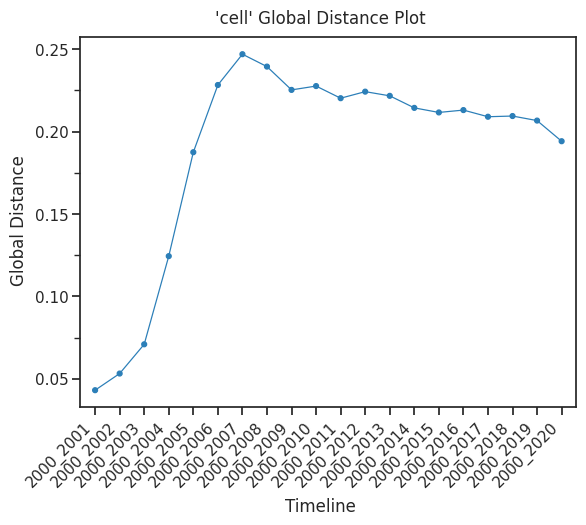

<ggplot: (8784172516707)>

In [59]:
global_distance

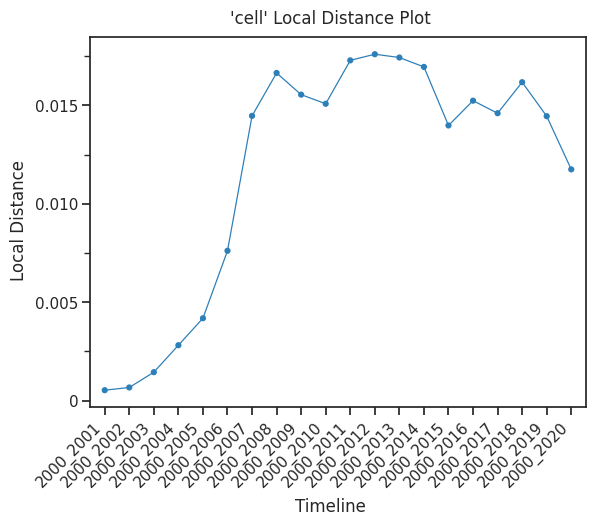

<ggplot: (-9223363252681017670)>

In [60]:
local_distance

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/timeline_figures/celltime_plot.png


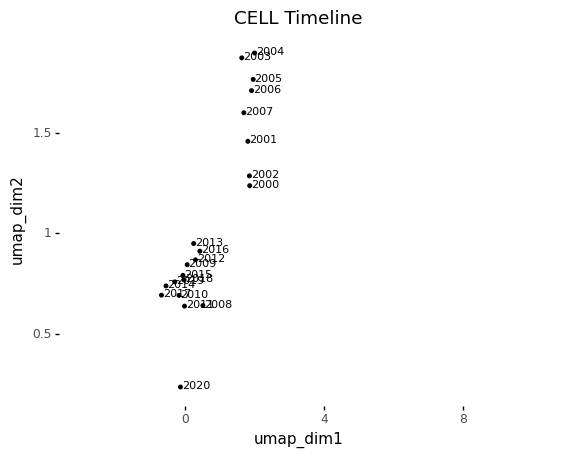

<ggplot: (8784172367869)>


In [61]:
g = plot_token_timeline(token_timeline_low_dim_df)
g.save("output/timeline_figures/celltime_plot.png")
print(g)

In [62]:
plot_wordcloud_neighbors_gif(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/cell.gif"
)

![cell gif here](output/wordcloud_plots_2000_2020/cell.gif)

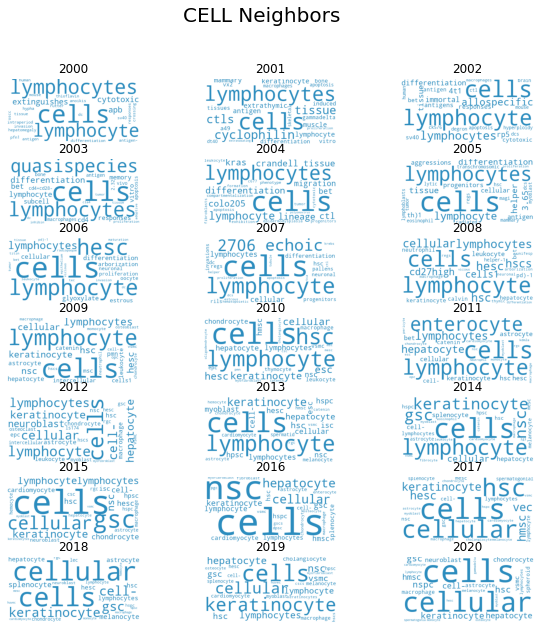

In [63]:
plot_wordcloud_neighbors(
    token_timeline_low_dim_df, plot_filename="output/wordcloud_plots_2000_2020/cell.png"
)

# Conclusions - Take Home Point(s)

1. Aligning vectors helps tremendously when measuring how words change their semantic meaning. Interesting spikes in the distance is words such as cystic, interleukin-18 and like 95%ci.
2. Plotting word clouds for the neighbor of each word highlights the shift these vectors are capturing
3. SpaCy likes to break hyphened words apart which makes capturing words such as RNA-seq and single-cell impossible to detect. Will need to update that if I want to have those words incorporated. Plus I need to use named entity recognition (NER tagger) to group nouns together as a high portion of biological terms are two words and not one.